In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import torch 
import torchvision
import torch.nn as nn
import scipy.io
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import time
import re
import cv2
import math

BATCH_SIZE = 12

# AqUavplant multiclass dataset loading

In [7]:
def find_numerical_part(string):
    # Use regex to find numerical part in the string
    numerical_part = re.findall(r'\d+', string)[0]
    return numerical_part

def excluding_classes(img, classes_toexclude):
    indices = np.where(np.isin(img, classes_toexclude))
    img[indices] = 0   #changes them to bg
    
    return img

from keras.utils import to_categorical
n_classes = 32

class aquatic_plant_dataset:
    def __init__(self, imagePaths, transforms, mode, img_target_shape = 512):
        # store the image and mask filepaths, and augmentation
        self.imagePaths = imagePaths
        #self.maskPaths = maskPaths
        self.transforms = transforms
        self.mode = mode
        self.train_list = []
        self.val_list = []
        self.test_list = []
        self.target_shape = (img_target_shape, img_target_shape)
        
        if(self.mode == 'train'):
            root_dir = self.imagePaths
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.train_list.append(os.path.join(root, directory))
        
        elif(self.mode == 'val'):
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.val_list.append(os.path.join(root, directory))
                        
        else:
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if('frame' in directory):
                        self.test_list.append(os.path.join(root, directory))

        
    def __len__(self):
        if(self.mode == 'train'):
            return len(self.train_list)
        elif(self.mode == 'val'):
            return len(self.val_list)
        else:
            return len(self.test_list)
    
    def __getitem__(self,idx):
        
        if(self.mode == 'train'):
            folder_dir = self.train_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_multiclass.png')  
            multi_mask = cv2.imread(image_path)  ##reading raw image
            multi_mask = cv2.cvtColor(multi_mask, cv2.COLOR_BGR2GRAY)
            
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
            
            if(self.transforms is not None):
                target_size = self.target_shape
                raw_img = cv2.resize(raw_img, target_size, interpolation=cv2.INTER_NEAREST)
                multi_mask = cv2.resize(multi_mask, target_size, interpolation=cv2.INTER_NEAREST)
            
            #multi_mask = excluding_classes(multi_mask, [11, 16, 17, 18, 23, 25])
            multi_mask_expand = to_categorical(multi_mask, num_classes=n_classes)
            
           
        elif(self.mode == 'val'):
            folder_dir = self.val_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_multiclass.png')  
            multi_mask = cv2.imread(image_path)  ##reading raw image
            multi_mask = cv2.cvtColor(multi_mask, cv2.COLOR_BGR2GRAY)
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
            
            if(self.transforms is not None):
                target_size = self.target_shape
                raw_img = cv2.resize(raw_img, target_size, interpolation=cv2.INTER_NEAREST)
                multi_mask = cv2.resize(multi_mask, target_size, interpolation=cv2.INTER_NEAREST)
            
            #multi_mask = excluding_classes(multi_mask, [11, 16, 17, 18, 23, 25])
            multi_mask_expand = to_categorical(multi_mask, num_classes=n_classes)#multi_mask = excluding_classes(multi_mask, [11, 16, 17, 18, 23, 25])
            
        else:
            folder_dir = self.test_list[idx]
            frame_name = folder_dir.split('/')[-1]
            loc_name = folder_dir.split('/')[-2]
            numeral = find_numerical_part(frame_name)
            image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_multiclass.png')  
            multi_mask = cv2.imread(image_path)  ##reading raw image
            multi_mask = cv2.cvtColor(multi_mask, cv2.COLOR_BGR2GRAY)
            
            raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  ##reading the raw file
            raw_img = cv2.imread(raw_path)  ##reading raw image
            
            if(self.transforms is not None):
                target_size = self.target_shape
                raw_img = cv2.resize(raw_img, target_size, interpolation=cv2.INTER_NEAREST)
                multi_mask = cv2.resize(multi_mask, target_size, interpolation=cv2.INTER_NEAREST)
            
            #multi_mask = excluding_classes(multi_mask, [11, 16, 17, 18, 23, 25])
            multi_mask_expand = to_categorical(multi_mask, num_classes=n_classes)        

            
        raw_img = np.transpose(raw_img, axes=(2, 0, 1))
        multi_mask_expand = np.transpose(multi_mask_expand, axes=(2, 0, 1))
        
        #print(raw_img.shape, multi_mask_expand.shape)
        return torch.from_numpy(raw_img),torch.from_numpy(multi_mask_expand), torch.from_numpy(multi_mask)
              
        
train_dataset = aquatic_plant_dataset('../input/final-run/Stratified_split/Train', True, 'train')
val_dataset = aquatic_plant_dataset('../input/final-run/Stratified_split/Validation', True, 'val')
test_dataset = aquatic_plant_dataset('../input/final-run/Stratified_split/Test', True, 'test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers = 0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = 0)   ##in testset batchsize is 1

2024-05-15 08:57:26.128752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 08:57:26.128802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 08:57:26.130433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
len(test_loader)

50

https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py

# Different models (Choose any one from the five and uncomment that block)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [10]:
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=32):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)
        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)
        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

model = U_Net().to(device)
print(model)

In [11]:
# class R2U_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=32,t=2):
#         super(R2U_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.Upsample = nn.Upsample(scale_factor=2)

#         self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

#         self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
#         self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
#         self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
#         self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.RRCNN1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.RRCNN2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.RRCNN3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.RRCNN4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.RRCNN5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         d5 = torch.cat((x4,d5),dim=1)
#         d5 = self.Up_RRCNN5(d5)
        
#         d4 = self.Up4(d5)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_RRCNN4(d4)

#         d3 = self.Up3(d4)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_RRCNN3(d3)

#         d2 = self.Up2(d3)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_RRCNN2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
# model = R2U_Net().to(device)
# print(model)

In [12]:
# class AttU_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=32):
#         super(AttU_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

#         self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
#         self.Conv2 = conv_block(ch_in=64,ch_out=128)
#         self.Conv3 = conv_block(ch_in=128,ch_out=256)
#         self.Conv4 = conv_block(ch_in=256,ch_out=512)
#         self.Conv5 = conv_block(ch_in=512,ch_out=1024)

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
#         self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
#         self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
#         self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
#         self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.Conv1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.Conv2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.Conv3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.Conv4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.Conv5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         x4 = self.Att5(g=d5,x=x4)
#         d5 = torch.cat((x4,d5),dim=1)        
#         d5 = self.Up_conv5(d5)
        
#         d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4,x=x3)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_conv4(d4)

#         d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3,x=x2)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_conv3(d3)

#         d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2,x=x1)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_conv2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
    
# model = AttU_Net().to(device)
# print(model)

In [13]:
# class R2AttU_Net(nn.Module):
#     def __init__(self,img_ch=3,output_ch=32,t=2):
#         super(R2AttU_Net,self).__init__()
        
#         self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.Upsample = nn.Upsample(scale_factor=2)

#         self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

#         self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
#         self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
#         self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
#         self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

#         self.Up5 = up_conv(ch_in=1024,ch_out=512)
#         self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
#         self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
#         self.Up4 = up_conv(ch_in=512,ch_out=256)
#         self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
#         self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
#         self.Up3 = up_conv(ch_in=256,ch_out=128)
#         self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
#         self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
#         self.Up2 = up_conv(ch_in=128,ch_out=64)
#         self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
#         self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

#         self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


#     def forward(self,x):
#         # encoding path
#         x1 = self.RRCNN1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.RRCNN2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.RRCNN3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.RRCNN4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.RRCNN5(x5)

#         # decoding + concat path
#         d5 = self.Up5(x5)
#         x4 = self.Att5(g=d5,x=x4)
#         d5 = torch.cat((x4,d5),dim=1)
#         d5 = self.Up_RRCNN5(d5)
        
#         d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4,x=x3)
#         d4 = torch.cat((x3,d4),dim=1)
#         d4 = self.Up_RRCNN4(d4)

#         d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3,x=x2)
#         d3 = torch.cat((x2,d3),dim=1)
#         d3 = self.Up_RRCNN3(d3)

#         d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2,x=x1)
#         d2 = torch.cat((x1,d2),dim=1)
#         d2 = self.Up_RRCNN2(d2)

#         d1 = self.Conv_1x1(d2)

#         return d1
    
# model = R2AttU_Net().to(device)
# print(model)

In [ ]:
# ###Deeplabv3

# from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
# from torchvision.models.segmentation import (
#                                             DeepLabV3_ResNet50_Weights, 
#                                              DeepLabV3_ResNet101_Weights, 
#                                              DeepLabV3_MobileNet_V3_Large_Weights
#                                              )
  
# #model_name == "resnet_50":
# #model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
# #transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

# #model_name == "resnet_101":
# model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
# #transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

# #model_name == "mobilenet":
# #model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
# #transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

# new_conv_layer = nn.Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))  ##256,1 was there
# model.classifier[-1] = new_conv_layer

# model = model.to(device)
# print(model)

# Model Parameters

In [16]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

lossfunc = nn.CrossEntropyLoss()
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=2e-5)

num_epoch = 100

# Training and Validation

In [ ]:
print("Start training the network...")
startTime = time.time()

val_loss = []
train_loss = []

best_loss = math.inf

for epoch in tqdm(range(num_epoch)):
    model.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (raw, gt, _)) in enumerate(train_loader):
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        
        ## pred = model(raw)["out"]   ##for deeplab v3
        pred = model(raw)
        loss = lossfunc(pred, gt)

        optim.zero_grad()
        loss.backward()
        optim.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        
    train_loss.append(totalTrainLoss.detach().cpu().numpy())
    
    with torch.no_grad():
        model.eval()
        for (raw, gt, _) in val_loader:
            (raw, gt) = (raw.to(device), gt.to(device))
            raw = raw.to(torch.float)
            gt = gt.to(torch.float)
            
            #pred = model(raw)["out"]   ##for deeplabv3
            pred = model(raw)
            curr_loss = lossfunc(pred, gt)
            totalTestLoss += curr_loss
    val_loss.append(totalTestLoss.detach().cpu().numpy()) 
    
    if(totalTestLoss<best_loss):
        print(f'Saving best weight at epoch: {epoch}.......')
        torch.save(model.state_dict(), f'model_weights.pth')    
        best_loss = totalTestLoss
            
    print(f"Train loss: {totalTrainLoss/i}, Val loss: {totalTestLoss/i}")
    
    print("EPOCH: {}/{}".format(epoch + 1, num_epoch))
    
    #print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("total time taken to train the model: {:.2f}s".format(endTime - startTime))

# Plotting Loss curve

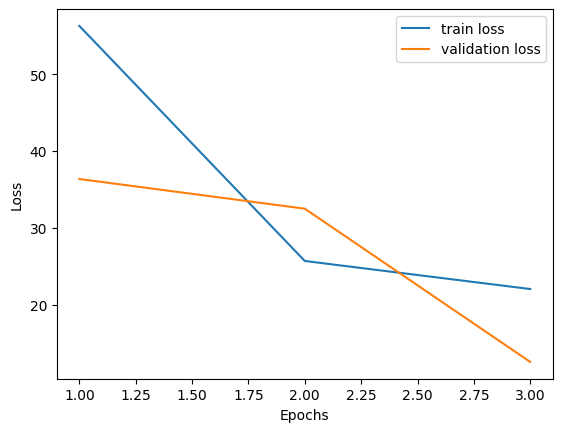

In [18]:
import matplotlib.pyplot as plt

# Example data
x = list(range(1,len(train_loss)+1))  
plt.plot(x, train_loss, label='train')  # Plot the first line and specify its label
plt.plot(x, val_loss, label='val')  # Plot the second line and specify its label

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'validation loss'])
plt.savefig('loss_curve_multiclass.png', dpi=300) 
plt.show()

# Evaluation metrics

In [19]:
from sklearn.metrics import f1_score

def calculate_accuracy(pred_mask, true_mask):
    # Flatten the predicted and true masks
    pred_flat = pred_mask.flatten()
    true_flat = true_mask.flatten()
    
    # Calculate pixel-wise accuracy
    accuracy = np.mean(pred_flat == true_flat)
    
    return accuracy

def dice_coefficient(ground_truth, predicted, num_classes):
    dice_scores = []
    
    for class_label in range(0, num_classes):
        # Convert tensors to numpy arrays
        ground_truth_np = ground_truth.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        # Calculate intersection and union for each class
        intersection = np.sum((ground_truth_np == class_label) & (predicted_np == class_label))
        union = np.sum((ground_truth_np == class_label) | (predicted_np == class_label))
        
        # Calculate Dice coefficient for the class
        dice = (2.0 * intersection) / (union + intersection + 1e-8)
        dice_scores.append(dice)
    
    # Calculate average Dice coefficient across all classes
    avg_dice = np.sum(dice_scores)/len(np.unique(ground_truth.cpu().numpy()))
    
    return avg_dice, dice_scores

def jaccard_index(ground_truth, predicted, num_classes):
    intersection = torch.zeros(num_classes)
    union = torch.zeros(num_classes)
    
    for class_label in range(0, num_classes):
        # Calculate intersection and union for each class
        intersection[class_label] = torch.sum(torch.logical_and(ground_truth == class_label, predicted == class_label))
        union[class_label] = torch.sum(torch.logical_or(ground_truth == class_label, predicted == class_label))
        union[class_label] += 1e-8
    # Calculate Jaccard Index for each class
    jaccard_per_class = intersection / union
    
    # Average Jaccard Index across all classes
    avg_jaccard = torch.sum(jaccard_per_class)/len(np.unique(ground_truth.cpu().numpy()))
    
    return avg_jaccard.item(), jaccard_per_class.numpy() 


def calc_accuracy(ground_truth, predicted):
    ground_truth_flat = ground_truth.view(-1)
    correct_predictions = torch.sum(ground_truth == predicted).item()
    total_pixels = ground_truth_flat.shape[0]
    accuracy = correct_predictions / total_pixels
    return accuracy


def multilabel_f1_score(ground_truth, predicted, average='weighted'):
    # Flatten both ground truth and predicted tensors
    ground_truth_flat = ground_truth.view(-1)
    predicted_flat = predicted.view(-1)
    
    # Convert tensors to NumPy arrays
    ground_truth_np = ground_truth_flat.cpu().numpy()
    predicted_np = predicted_flat.cpu().numpy()
    
    # Compute F1 score
    f1 = f1_score(ground_truth_np, predicted_np, average=average)
    
    return f1

# Results on Testset

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/model_weights.pth'))

with torch.no_grad():
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    jaccard_score = 0
    acc = 0
    f1score = 0
    j_class_all = torch.zeros([32])
    d_class_all = np.zeros([32])
    model.eval()
    # loop over the validation set
    for i, (raw, _ , gt) in enumerate(test_loader):
        #print(torch.unique(gt))
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        
        #pred = model(raw)["out"]
        softmax = nn.Softmax(dim=1)
        pred = torch.argmax(softmax(model(raw)["out"]),axis=1)
        
        gt = gt.to(torch.uint8)
        pred = pred.to(torch.uint8)
        dice, dice_class = dice_coefficient(gt, pred, 32)
        jaccard, j_class = jaccard_index(gt, pred, 32)
        accuracy = calc_accuracy(gt, pred)
        f1 = multilabel_f1_score(gt, pred)
        #dice = (2 * (pred * gt).sum()) / ((pred + gt).sum() + 1e-8)
        dice_score += dice
        jaccard_score += jaccard
        acc += accuracy
        f1score += f1
        
        j_class_all += j_class
        d_class_all += dice_class
        
        #print(j_class, torch.unique(gt))
        #print(dice, jaccard, accuracy, f1)
        
print(f"Total Dice co-efficient is {dice_score/i}, jaccard index is {jaccard_score/i}, accuracy: {acc/i}")
#print(f"total test loss {totaltestloss/i}, acc is {totaltestacc/i},f1 is {totaltestf1/i} dice is {totaltestdice/i}, JS is {totaltestJS/i}")

# Classwise score

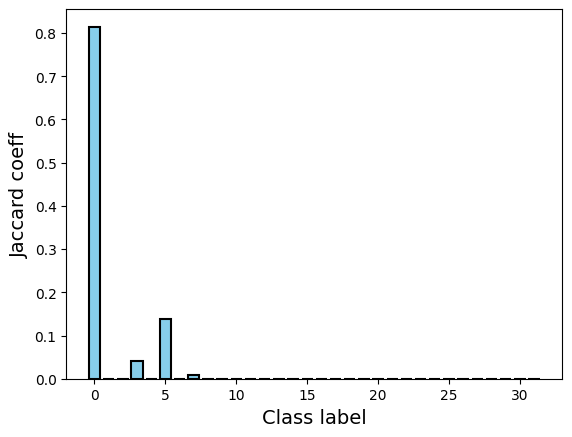

In [24]:
classwisescore = j_class_all/i

plt.bar(range(len(classwisescore)), classwisescore, color='skyblue', edgecolor='black', linewidth=1.5)
plt.xlabel('Class label', fontsize=14)
plt.ylabel('Jaccard coeff', fontsize=14)
#plt.title('Classwise test dice coefficient')
plt.savefig('jaccard_classwise.png', dpi=600) 
plt.show()

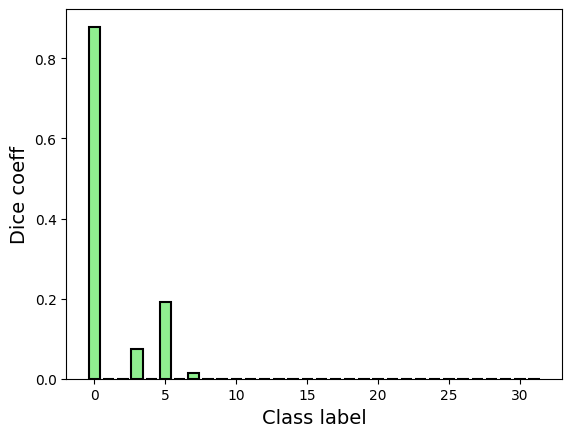

In [25]:
classwisescore_dice = d_class_all/i

plt.bar(range(len(classwisescore_dice)), classwisescore_dice, color='lightgreen', edgecolor='black', linewidth=1.5)
plt.xlabel('Class label', fontsize=14)
plt.ylabel('Dice coeff', fontsize=14)
#plt.title('Classwise test dice coefficient')
plt.savefig('dice_classwise.png', dpi=600) 
plt.show()

# Score saving

In [26]:
with open('multiclass_scores.txt', 'w') as file:
    file.write(f'Dice co-efficient: {dice_score/i}\n')
    file.write(f'Jaccard index: {jaccard_score/i}\n')
    file.write(f'Accuracy: {acc/i}\n')
    file.write(f'f1_score (weighted): {f1score/i}\n')
    file.write(f'classwise jaccard: {classwisescore}\n')
    file.write(f'classwise dice: {classwisescore_dice}\n')
    